<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/code_only_t3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!gsutil -m cp gs://3d-shapes/3dshapes.h5 .

Copying gs://3d-shapes/3dshapes.h5...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1/1 files][255.2 MiB/255.2 MiB] 100% Done                                    
Operation completed over 1 objects/255.2 MiB.                                    


In [3]:
f = h5py.File('3dshapes.h5', 'r')
print("Claves del archivo:", list(f.keys()))

# Forma de las imágenes,etiquetas y formato
print("Tamaño de las imágenes:", f['images'].shape)
print("Tamaño de los labels:  ", f['labels'].shape)
print(type(f['labels']))

Claves del archivo: ['images', 'labels']
Tamaño de las imágenes: (480000, 64, 64, 3)
Tamaño de los labels:   (480000, 6)
<class 'h5py._hl.dataset.Dataset'>


In [4]:
from torchvision import transforms
from PIL import Image

transform = transforms.ToTensor()

In [5]:
class Shapes3D(Dataset):

    def __init__(self, filename, max_samples=None, seed=0):
        # nombre del archivo guardado
        self.filename = filename
        # se abre el archivo en el formato HDF5 para leer 'r'
        self.file = h5py.File(self.filename, 'r')

        # se guardan las imágenes y etiquetas
        self._images = self.file['images']
        self._labels = self.file['labels']

        # cantidad de imágenes en total
        self.total_samples = len(self._images)

        # índices se sacan de forma aleatoria para tomar muestra
        # replace = False es que sean distintos
        if max_samples is not None:
            rng = np.random.default_rng(seed)  # generador random con semilla
            self.indices = rng.choice(self.total_samples, size=max_samples, replace=False)
        else:
            self.indices = np.arange(self.total_samples)

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)  # cantidad de índices guardados

    def __getitem__(self, n):
        i = self.indices[n]  # se busca el índice
        img = self._images[i]
        # capturamos la imagen y su etiqueta asociada
        img = Image.fromarray(img)
        img = self.transform(img)  # normalización pasa de (0,255) a (0,1)
        # img = np.clip(img, 0.0, 1.0)

        # img = np.transpose(img, (2, 0, 1))  # cambia orden de ejes: alto, ancho, canales → canales, alto, ancho
        # img = torch.from_numpy(img).float()
        label = torch.from_numpy(self._labels[i]).float()

        return img, label

In [8]:
batch_size = 64
max_samples = 1000

dataset = Shapes3D(filename='3dshapes.h5', max_samples=max_samples)
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [9]:
# Ver el primer batch
for images, labels in dataloader:
    print("Tamaño del batch de imágenes:", images.shape)
    print("Tamaño del batch de labels:", labels.shape)

Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 3, 64, 64])
Tamaño del batch de labels: torch.Size([64, 6])
Tamaño del batch de imágenes: torch.Size([64, 

In [10]:
def show_images(imgs, ncols=None):
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    n_images = imgs.shape[0]
    ncols = ncols or int(n_images**0.5)
    nrows = -(-n_images // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(img)
        ax.axis('off')
    for ax in axes.flat[n_images:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

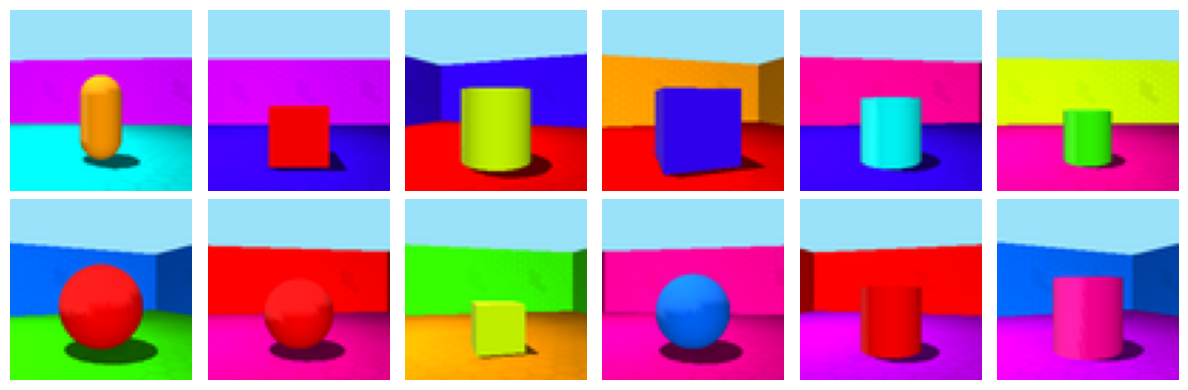

In [11]:
imgs, labels = next(iter(dataloader))
assert imgs.shape == (batch_size, 3, 64, 64)
assert labels.shape == (batch_size, 6)

show_images(imgs[:12], ncols=6)

In [12]:

class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2), # activación suave

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2)
        )
    # Arquitectura: 3 canales de 64x64 -> 32 canales de 32x32 ->
    #               64 canales de 16x16 -> 128 canales de 8x8
    self.flatten = nn.Flatten()

    self.fc_mu = nn.Linear(256*4*4, latent_dim)
    self.fc_logvar = nn.Linear(256*4*4, latent_dim)

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x) # (N,256)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    # Proyecta el vector latente a  un tensor de 128x8x8 para usarlo como entrada
    # de las capas conv

    self.dec = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),  # proyectamos al tamaño original
            nn.LeakyReLU(negative_slope=0.2),
            nn.Unflatten(1, (256, 4, 4)),  # lo convertimos a forma de imagen (batch, C, H, W)

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # para que la salida quede en [0,1]
        )


  def forward(self, z):
    return self.dec(z)

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
      # reparametrizamos z para que sea calculable

        std = torch.exp(0.5 * logvar)
        ep_noise = torch.randn_like(mu) # tensor de numeros aleatorios ~N(0,1) con dim igual a mu
        return mu + ep_noise * std # Agregamos ruido a la Gaussiana


    def forward(self, x):
        mu, logvar = self.encoder(x)

        z_noise = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z_noise)
        return (mu, logvar), x_recon # x_reconstruido


def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):

    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                # Entrenamiento -----------------------------------------------
                # El codigo debe permitir usar istintas métricas de recontrucción
                # Agregar parámetro beta -> beta-VAE
                optimizer.zero_grad()

                # ELBO:
                (encoder_mu, encoder_logvar), x_recon = model(x)
                encoder_var = encoder_logvar.exp()


                prior_matching = -0.5 * torch.sum(1 + encoder_logvar -
                                                 encoder_mu.pow(2) -
                                                 encoder_var , dim=1
                                                  )
                # prior_matching = 1/2 * (encoder_mu.norm(dim=-1) ** 2 + \
                #                         encoder_var.norm(dim=-1) ** 2) - \
                #                         encoder_logvar.sum(dim=-1)

                prior_matching = prior_matching.mean()


                reconstruction = reconstruction_metric(x_recon, x)

                loss = reconstruction + beta * prior_matching
                # loss = loss.mean()
                # print('loss ', loss, ' prior', prior_matching, 'recont ', reconstruction)

                loss.backward()
                optimizer.step()

                # Registro -----------------------------------------------------

                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # Gráfico --------------------------------------------------------------

        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylabel('Escala término de reconstrucción')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylabel('Escala prior matching')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()


In [13]:
def reconstruction(x, model):
  z_mean, z_logvar = model.encoder(x)

  z = z_mean + torch.exp(0.5*z_logvar) * torch.randn_like(z_mean)
  x_mean = model.decoder(z)
  return x_mean

In [14]:
imgs, _ = next(iter(dataloader))
x_original = imgs[:6].to(DEVICE)

Entrenamiento:   0%|          | 0/960 [00:00<?, ?it/s]

Entrenamiento interrumpido.


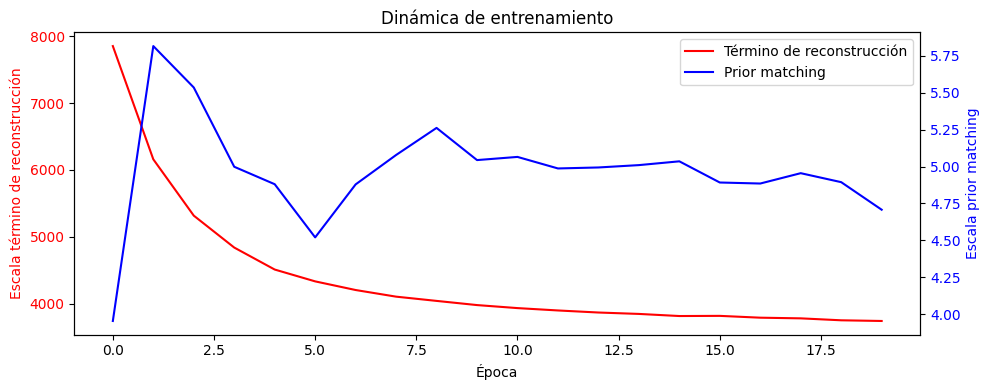

In [15]:
latent_dim = 64
reconstruction_metric = nn.BCELoss(reduction='sum')
beta = 4.5
n_epochs = 60
model = VAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters())#, lr=1e-4)
train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)

Modelo interrumpido en la epoca 21

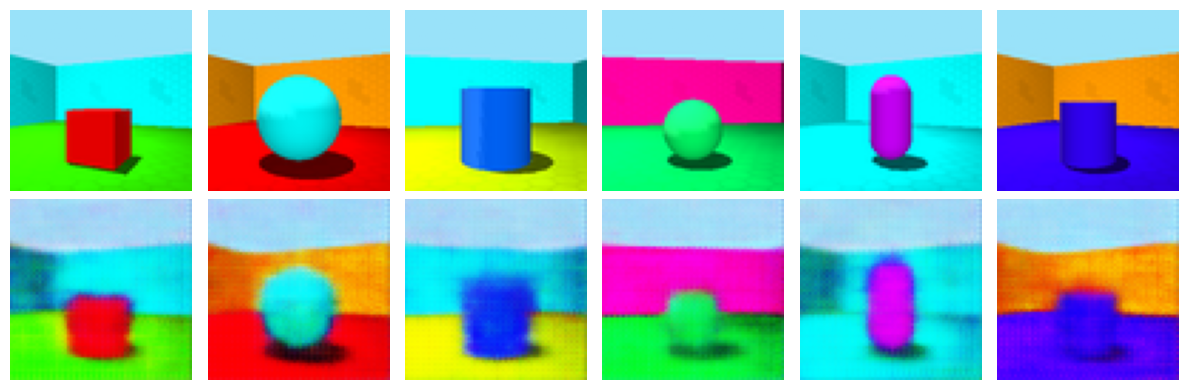

In [16]:
x_reconstruction = reconstruction(x_original, model)
show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))

In [17]:
# latent_dim = 60
# reconstruction_metric = nn.MSELoss(reduction='sum')
# beta = 2
# n_epochs = 60
# model = VAE(latent_dim)
# optimizer = torch.optim.Adam(model.parameters())#, lr=1e-4)
# train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)

In [18]:
# x_reconstruction = reconstruction(x_original, model)
# show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))

In [19]:
# Guardamos el modelo para no tener que correrlo cada vez que se trabaje
torch.save(model, '/content/drive/MyDrive/vae_model_bce.pth')


In [20]:
# Cargo el modelo previamente entrenado
model = torch.load('/content/drive/MyDrive/vae_model_bce.pth', weights_only=False)
model.eval()

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_mu): Linear(in_features=4096, out_features=64

### Generación de nuevas muestras


- Implemente la función `generate_samples` que genere muestras nuevas a partir del VAE.

In [21]:
def generate_samples(model, n_samples):
  z = torch.randn(n_samples, model.latent_dim)
  return model.decoder(z)

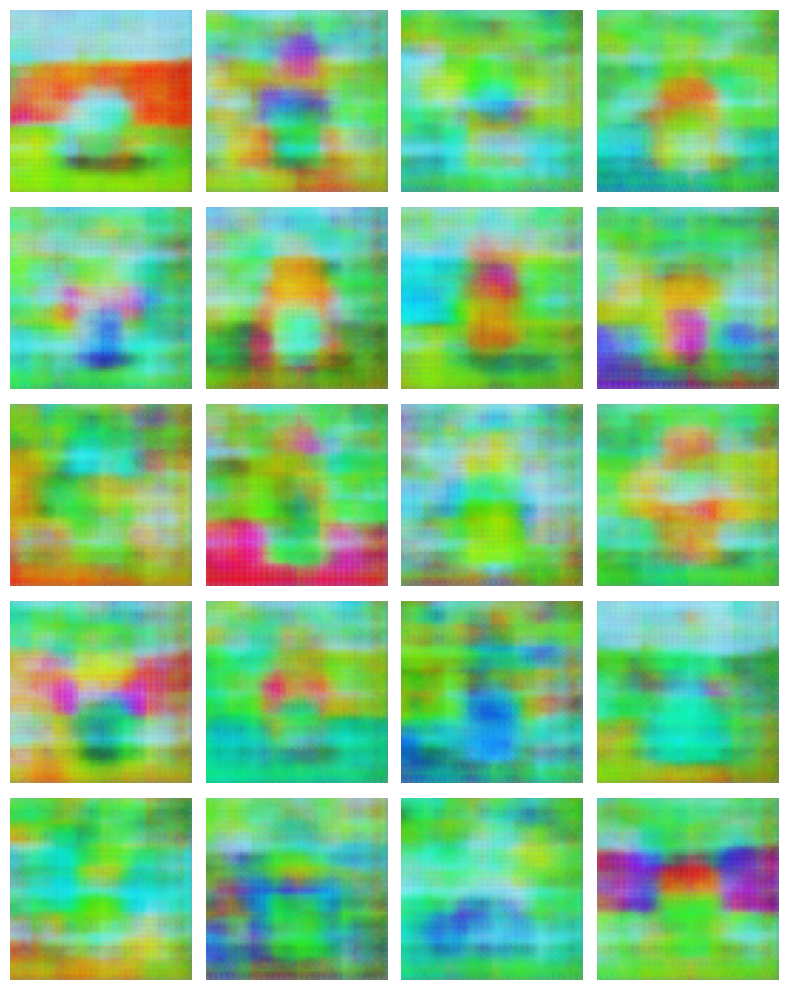

In [22]:
samples = generate_samples(model, n_samples=20)
show_images(samples)

### Interpolación

El objetivo de esta pregunta es ver la diferencia entre una interpolación en el espacio de pixeles y el espacio latente inducido por el VAE.

#### Interpolación en el espacio de pixeles

- Implemente la función `interpolate_pixels` que interpole linealmente 2 imágenes. Notar que esta función no hace uso del VAE.

In [23]:
def interpolate_pixels(x1, x2, steps=8):
    # x_alpha = (1 - alpha)x1 + alpha x2

    x_interpolado = []
    for alpha in range(steps):
      x_alpha = (1 - alpha/steps) * x1 + alpha/steps * x2
      x_interpolado.append(x_alpha)

    return torch.stack(x_interpolado)


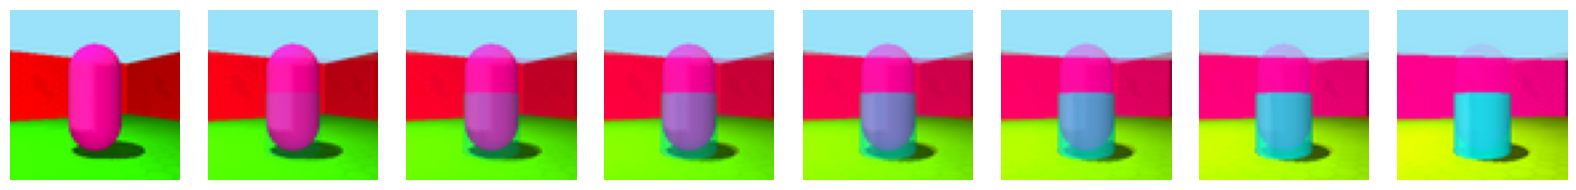

In [24]:
imgs, _ = next(iter(dataloader))

x1, x2 = imgs[0:2]
pixel_interpolation = interpolate_pixels(x1, x2, steps=8)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

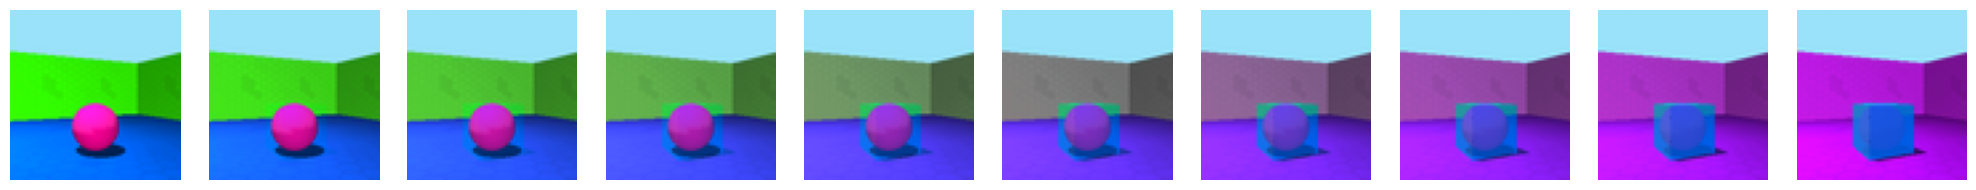

In [25]:
imgs, _ = next(iter(dataloader))

x1, x2 = imgs[10:12]
pixel_interpolation = interpolate_pixels(x1, x2, steps=10)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

#### Interpolación en el espacio latente

- Implemente la función `interpolate_latents` que interpole 2 imágenes en el espacio latente del VAE entrenado.

In [26]:
def interpolate_latents(x1, x2, model, steps=8):
  # z_aplha =  (1-alpha) * z1 + alpha * z2

  # # Variables latentes
    z1, _ = model.encoder(x1.unsqueeze(0))
    z2, _ = model.encoder(x2.unsqueeze(0))

    # Interpolacion
    x_interpolado = []
    for step in range (steps):
      # print(step)
      alpha = step/steps
      z_t = (1 - alpha) * z1 + alpha * z2
      x_t = model.decoder(z_t)
      x_interpolado.append(x_t.squeeze(0))

    return torch.stack(x_interpolado)


Imagen X1


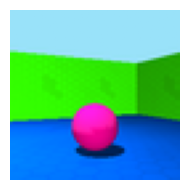

Imagen X2


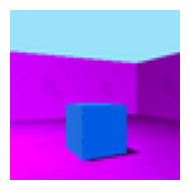

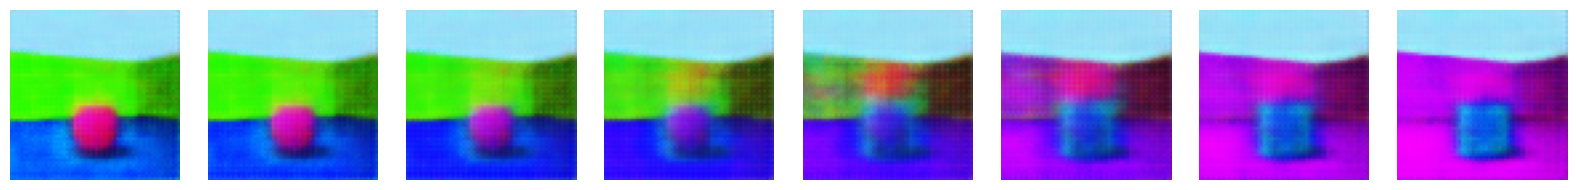

In [27]:
imgs, _ = next(iter(dataloader))

# Se interpolan las mismas imágenes usadas en interpolate_pixels:
pixel_interpolation = interpolate_latents(x1, x2, model)

print('Imagen X1')
show_images(x1.unsqueeze(0), ncols=len(x1))
print('Imagen X2')
show_images(x2.unsqueeze(0), ncols=len(x2))
show_images(pixel_interpolation, ncols=len(pixel_interpolation))

### Aritmética en el espacio latente

El objetivo de esta pregunta es realizar aritmética de atributos, donde los atributos, en este caso, vienen dados en la lista `_FACTORS_IN_ORDER` definida al comienzo.

Recordar que, para un atributo dado, se puede calcular un centroide de dicho atributo, $z_{\text{atributo}}\in\mathbb{R}^L$, promediando representaciones latentes de muestras que posean dicho atributo. Con esto, restando los centroides de dos atributos diferentes se obtiene un vector latente director, $z_{\text{director}}\in\mathbb{R}^L$, el cual puede usarse para modificar atributos de una muestra $x\in\mathbb{R}^D$ mediante $x_\lambda = \text{decoder}(\text{encoder}(x)+\lambda z_\text{director})$, donde $\lambda>0$ es un parámetro de traslación.

- Implemente la función `attribute_arithmetic`, la cual recibe 2 diccionarios (`source_attributes` y `target_attributes`) con los atributos que se usarán para definir el vector director. Este vector debe ser aplicado a una imagen dada (`test_img`) usando los ponderadores definidos en la lista `ponderators`.

In [28]:
# _FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [29]:
def attribute_arithmetic(model, dataset, source_attributes, target_attributes, test_img, ponderators):
  # centroide del atributo (promedio representaciones latentes)
  # z_director = centroide1 -centroide2

  def match_attributes(label, attributes):
      factors_in_order = ['floor_hue', 'wall_hue', 'object_hue', 'scale',
                          'shape', 'orientation']
      for attr_name, attr_value in attributes.items():
        factor_idx = factors_in_order.index(attr_name)

        # Comparo el valor de la label en el índice correspondiente
        if label[factor_idx] != attr_value:
          return False
      return True # retorna true si la etiqueta coincide en todas las cond.

  z_mu_source, z_mu_target = [], []

  model.eval()
  for x, label in dataset:

    with torch.no_grad():
      z_mu, _ = model.encoder(x.unsqueeze(0))

    z_mu = z_mu.squeeze(0).detach()

    # Reviso si la muestra pertenece a las representaciones de target o source
    if match_attributes(label, target_attributes):
      z_mu_target.append(z_mu)

    if match_attributes(label, source_attributes):
      z_mu_source.append(z_mu)

  # --------------------------------------------------------------------------
  # Promedio las representaciones
  centroide_target = torch.stack(z_mu_target).mean(dim=0)
  centroide_source = torch.stack(z_mu_source).mean(dim=0)

  # --------------------------------------------------------------------------
  # Calculo el vector director
  z_director = centroide_target - centroide_source

  # --------------------------------------------------------------------------
  # Desplazo la imagen en la direccion del atributo
  # x_lambda = decoder(encoder(x) + lambda *z_director)

  x_desplazada = [] # genero una lista vacía porque tengo una lista de ponderadores


  with torch.no_grad():
    z_original, _ = model.encoder(test_img.unsqueeze(0))

  for step in ponderators:
    z_desplazado_step = z_original + step * z_director.unsqueeze(0)

    with torch.no_grad():
      x_desplazado = model.decoder(z_desplazado_step)
    x_desplazada.append(x_desplazado.squeeze(0))

  return torch.stack(x_desplazada)



Imagen Original


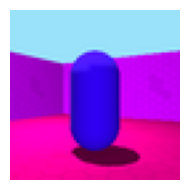

Imagen Transformada


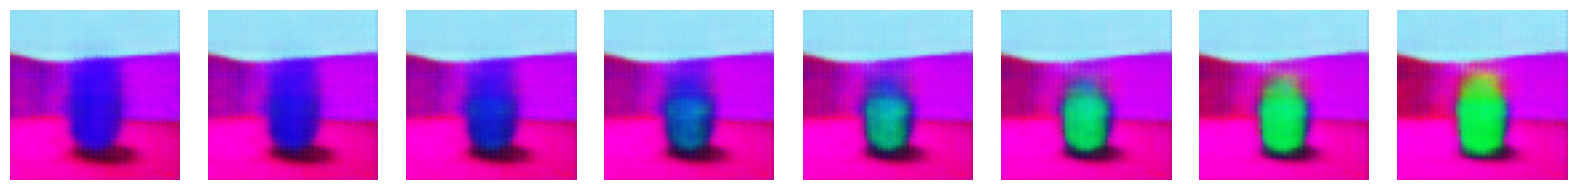

In [30]:
# Imagen de prueba:
test_img, test_label = dataset[30]
ponderators = torch.linspace(0, 1, 8).tolist()

# Transformar forma original (cubo) -> esfera:
source_attributes = {'shape': test_label[4], 'object_hue': test_label[2]}
target_attributes = {'shape': 1, 'object_hue': 0.4} # Cambio la forma a cilindro y color del objeto a verde

displaced_img = attribute_arithmetic(model, dataset, source_attributes,
                                     target_attributes, test_img, ponderators)

print('Imagen Original')
show_images(test_img.unsqueeze(0), ncols=len(test_img))
print('Imagen Transformada')
show_images(displaced_img, ncols=len(displaced_img))

Es importante notar que si bien cambia el color de objeto, también está afectando a otros atributos como el color de la pared. Además, apenas se puede apreciar el cambio de forma del objeto, hecho que debería solucionarse aumentando elnúmero de épocas y escogiendo una cantidad correcta de dimensiones latentes.